In [1]:
import os
from PIL import Image
from torch.utils.data import Dataset, random_split, DataLoader
import torch.nn as nn
import torchvision.transforms.functional as TF
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import zipfile
import numpy
from torch.utils.data import Subset
from torchvision import transforms

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
class SegmentationOrientedDefectDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_names = sorted(os.listdir(image_dir))
        self.mask_names = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_names[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_names[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # grayscale (for binary)

        if self.transform:
            image, mask = self.augment(image, mask)

        # Normalize image and convert to tensor
        image = TF.to_tensor(image)
        image = TF.normalize(image, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

        # Convert mask to tensor and binarize
        mask = TF.to_tensor(mask)
        mask = (mask > 0.5).float()  # Ensure binary mask (0 or 1)

        return image, mask

    def augment(self, image, mask):
        # Random Horizontal Flip
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Then the Random Vertical Flip
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        # Random rotation
        angle = random.choice([0, 90, 180, 270])
        image = TF.rotate(image, angle)
        mask = TF.rotate(mask, angle)

        return image, mask

In [4]:
dataset_path = 'combined_dataset'

image_dir = os.path.join(dataset_path, "images")
mask_dir = os.path.join(dataset_path, "masks")

# dataset = SegmentationOrientedDefectDataset(image_dir, mask_dir, transform=True)
full_dataset = SegmentationOrientedDefectDataset(image_dir, mask_dir, transform=True)

random_indices = random.sample(range(len(full_dataset)), 5000)
dataset = Subset(full_dataset, random_indices)

# We will split it into train, val, test (e.g., 70%, 15%, 15%)
train_size = int(0.7*len(dataset))
val_size = int(0.15*len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [5]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False)

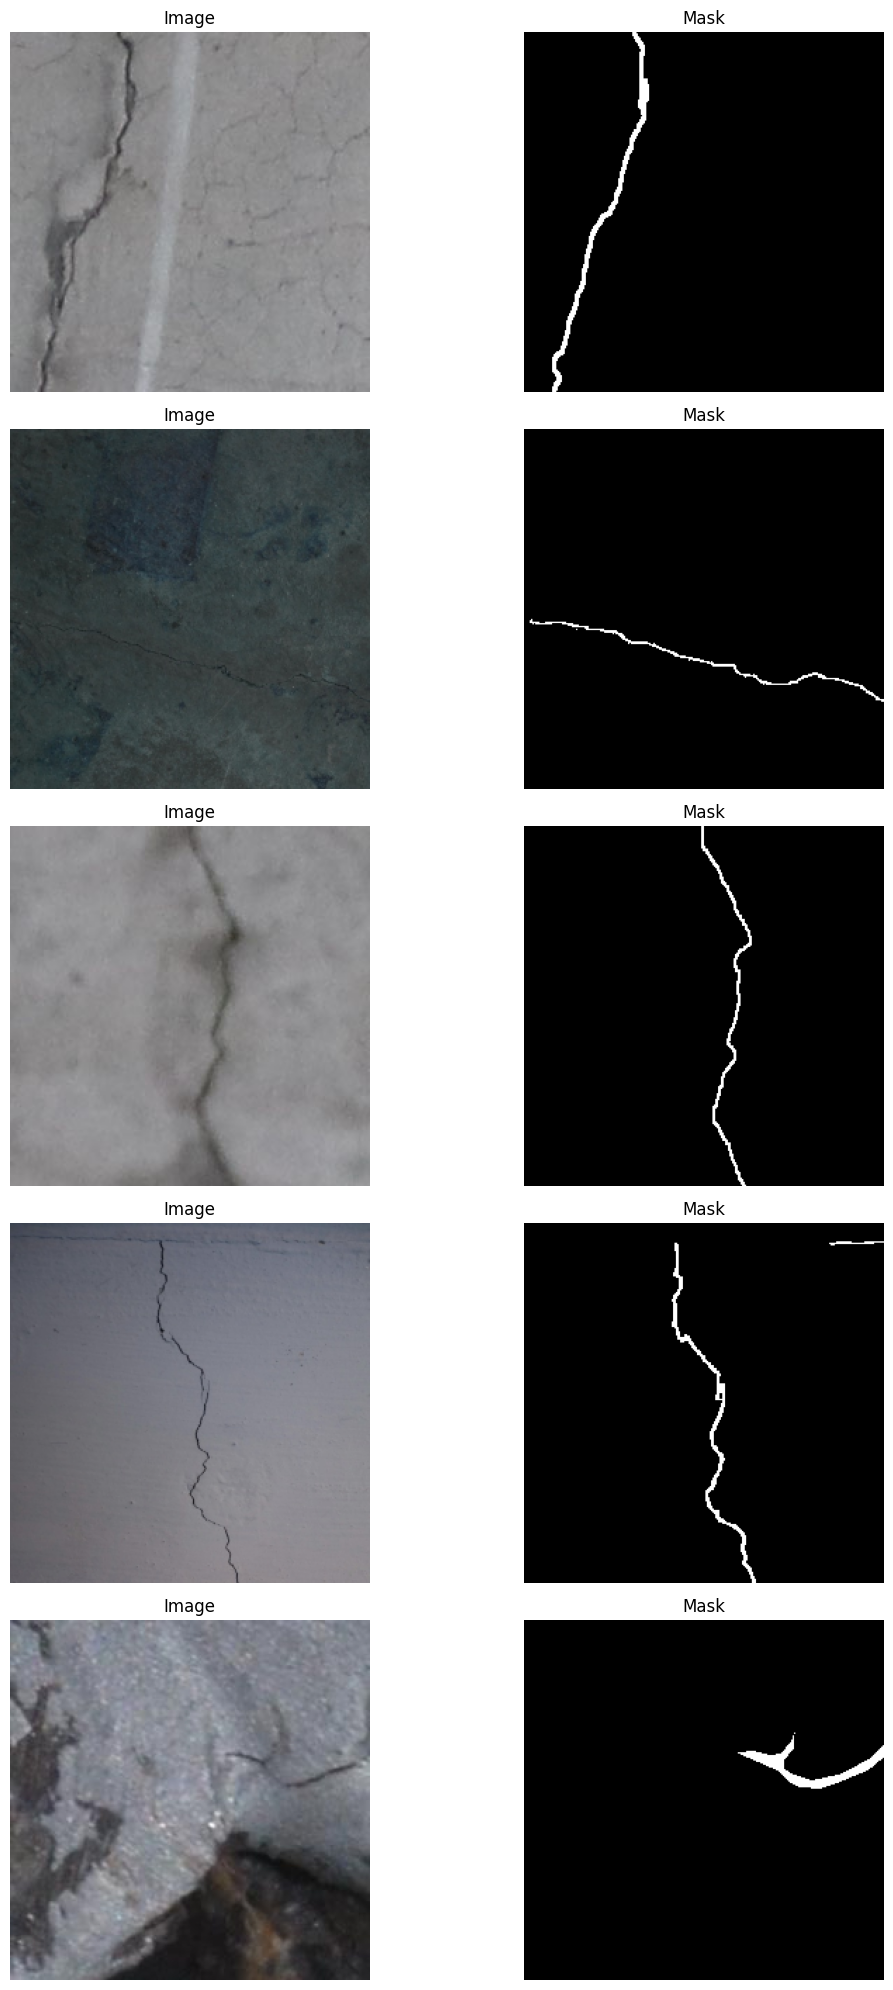

In [6]:
def visualize_dataset(data_loader, num_samples=4):
    images, masks = next(iter(data_loader))

    images = images * 0.5 + 0.5
    images = images.numpy()
    masks  = masks.numpy()

    plt.figure(figsize=(12, 4 * num_samples))

    for i in range(num_samples):
        img = images[i].transpose(1, 2, 0)  # CHW -> HWC
        mask = masks[i][0]  # binary mask (1, H, W) -> (H, W)

        # Plot image
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(img)
        plt.title("Image")
        plt.axis("off")

        # Plot mask
        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_dataset(train_loader, num_samples=5)

In [6]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(3, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.encoder3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.bottle_neck = conv_block(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.decoder3 = conv_block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.decoder2 = conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.output = nn.Conv2d(64, 1, kernel_size=1)  # As we want the binary output

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool1(e1))
        e3 = self.encoder3(self.pool2(e2))

        b = self.bottle_neck(self.pool3(e3))

        d3 = self.up3(b)
        d3 = self.decoder3(torch.cat([d3, e3], dim=1))

        d2 = self.up2(d3)
        d2 = self.decoder2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)
        d1 = self.decoder1(torch.cat([d1, e1], dim=1))

        out = self.output(d1)

        return out

In [7]:
def dice_coefficient(preds, targets, threshold=0.5):
    preds = (torch.sigmoid(preds) > threshold).float()
    intersection = (preds * targets).sum()
    return (2. * intersection) / (preds.sum() + targets.sum() + 1e-8)

def iou_score(preds, targets, threshold=0.5):
    preds = (torch.sigmoid(preds) > threshold).float()
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    return intersection / (union + 1e-8)

In [8]:
from tqdm import tqdm

def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=30):
    best_val_dice = 0.0

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_dice = 0.0

        for images, masks in tqdm(train_loader, desc="Training", leave=False):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_dice += dice_coefficient(outputs, masks).item()

        train_loss = train_loss / len(train_loader)
        train_dice = train_dice / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        val_iou = 0.0

        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc="Validating", leave=False):
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)

                val_loss += loss.item()
                val_dice += dice_coefficient(outputs, masks).item()
                val_iou += iou_score(outputs, masks).item()

        val_loss = val_loss / len(val_loader)
        val_dice = val_dice / len(val_loader)
        val_iou = val_iou / len(val_loader)

        print(f"Epoch [{epoch+1}/{epochs}]")
        print(f"Train Loss: {train_loss:.4f} | Dice: {train_dice:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Dice: {val_dice:.4f} | IoU: {val_iou:.4f}\n")

        # Save checkpoint
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save(model.state_dict(), "model_saved")
            print(f"Saved new best model (Dice: {val_dice:.4f})")

In [9]:
model = UNet().to(device)

learning_rate = 1e-3
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_model(model, train_loader, val_loader, optimizer, criterion, epochs=30)

Epoch [1/30]
Train Loss: 0.2116 | Dice: 0.0010
Val Loss: 0.1061 | Dice: 0.0000 | IoU: 0.0000



Epoch [2/30]
Train Loss: 0.0978 | Dice: 0.0000
Val Loss: 0.0909 | Dice: 0.0000 | IoU: 0.0000



Epoch [3/30]
Train Loss: 0.0902 | Dice: 0.0000
Val Loss: 0.0869 | Dice: 0.0000 | IoU: 0.0000



Epoch [4/30]
Train Loss: 0.0877 | Dice: 0.1200
Val Loss: 0.0852 | Dice: 0.2500 | IoU: 0.1437

Saved new best model (Dice: 0.2500)


Epoch [5/30]
Train Loss: 0.0839 | Dice: 0.2739
Val Loss: 0.0904 | Dice: 0.3001 | IoU: 0.1794

Saved new best model (Dice: 0.3001)


Epoch [6/30]
Train Loss: 0.0847 | Dice: 0.1497
Val Loss: 0.0809 | Dice: 0.3643 | IoU: 0.2250

Saved new best model (Dice: 0.3643)


Epoch [7/30]
Train Loss: 0.0805 | Dice: 0.3384
Val Loss: 0.0774 | Dice: 0.3059 | IoU: 0.1821



Epoch [8/30]
Train Loss: 0.0797 | Dice: 0.3101
Val Loss: 0.0739 | Dice: 0.4058 | IoU: 0.2569

Saved new best model (Dice: 0.4058)


Epoch [9/30]
Train Loss: 0.0777 | Dice: 0.3361
Val Loss: 0.0742 | Dice: 0.3522 | IoU: 0.2152



Epoch [10/30]
Train Loss: 0.0736 | Dice: 0.3758
Val Loss: 0.0681 | Dice: 0.4139 | IoU: 0.2622

Saved new best model (Dice: 0.4139)


Epoch [11/30]
Train Loss: 0.0712 | Dice: 0.3849
Val Loss: 0.0655 | Dice: 0.4672 | IoU: 0.3055

Saved new best model (Dice: 0.4672)


Epoch [12/30]
Train Loss: 0.0669 | Dice: 0.4373
Val Loss: 0.0637 | Dice: 0.5074 | IoU: 0.3418

Saved new best model (Dice: 0.5074)


Epoch [13/30]
Train Loss: 0.0672 | Dice: 0.4301
Val Loss: 0.0677 | Dice: 0.4121 | IoU: 0.2607



Epoch [14/30]
Train Loss: 0.0650 | Dice: 0.4528
Val Loss: 0.0637 | Dice: 0.3757 | IoU: 0.2319



Epoch [15/30]
Train Loss: 0.0647 | Dice: 0.4431
Val Loss: 0.0606 | Dice: 0.4872 | IoU: 0.3231



Epoch [16/30]
Train Loss: 0.0619 | Dice: 0.4797
Val Loss: 0.0569 | Dice: 0.5363 | IoU: 0.3674

Saved new best model (Dice: 0.5363)


Epoch [17/30]
Train Loss: 0.0602 | Dice: 0.5018
Val Loss: 0.0558 | Dice: 0.5882 | IoU: 0.4180

Saved new best model (Dice: 0.5882)


Epoch [18/30]
Train Loss: 0.0589 | Dice: 0.5118
Val Loss: 0.0559 | Dice: 0.5500 | IoU: 0.3798



Epoch [19/30]
Train Loss: 0.0577 | Dice: 0.5323
Val Loss: 0.0543 | Dice: 0.5514 | IoU: 0.3822



Epoch [20/30]
Train Loss: 0.0575 | Dice: 0.5243
Val Loss: 0.0524 | Dice: 0.5788 | IoU: 0.4082



Epoch [21/30]
Train Loss: 0.0556 | Dice: 0.5459
Val Loss: 0.0572 | Dice: 0.4880 | IoU: 0.3237



Epoch [22/30]
Train Loss: 0.0555 | Dice: 0.5396
Val Loss: 0.0535 | Dice: 0.5083 | IoU: 0.3417



Epoch [23/30]
Train Loss: 0.0558 | Dice: 0.5365
Val Loss: 0.0530 | Dice: 0.5522 | IoU: 0.3829



Epoch [24/30]
Train Loss: 0.0541 | Dice: 0.5546
Val Loss: 0.0503 | Dice: 0.5834 | IoU: 0.4128



Epoch [25/30]
Train Loss: 0.0531 | Dice: 0.5705
Val Loss: 0.0512 | Dice: 0.6203 | IoU: 0.4510

Saved new best model (Dice: 0.6203)


Epoch [26/30]
Train Loss: 0.0540 | Dice: 0.5548
Val Loss: 0.0573 | Dice: 0.6216 | IoU: 0.4530

Saved new best model (Dice: 0.6216)


Epoch [27/30]
Train Loss: 0.0536 | Dice: 0.5651
Val Loss: 0.0517 | Dice: 0.6179 | IoU: 0.4478



Epoch [28/30]
Train Loss: 0.0512 | Dice: 0.5848
Val Loss: 0.0479 | Dice: 0.6454 | IoU: 0.4776

Saved new best model (Dice: 0.6454)


Epoch [29/30]
Train Loss: 0.0519 | Dice: 0.5764
Val Loss: 0.0486 | Dice: 0.5970 | IoU: 0.4264



Epoch [30/30]
Train Loss: 0.0508 | Dice: 0.5876
Val Loss: 0.0480 | Dice: 0.6244 | IoU: 0.4551



In [ ]:
torch.save(model.state_dict(), "UNet_segmentation.pth")

In [10]:
def visualize_prediction(image, mask, pred, alpha=0.6):
    """
    Visualizes the image, ground truth, predicted mask, and overlay of predicted mask on image.
    
    Parameters:
        image (Tensor): Original image tensor (C, H, W)
        mask (Tensor): Ground truth mask tensor (1, H, W)
        pred (Tensor): Predicted binary mask tensor (1, H, W)
        alpha (float): Transparency factor for overlay
    """
    image_np = image.cpu().permute(1, 2, 0).numpy()
    mask_np = mask.cpu().squeeze().numpy()
    pred_np = pred.cpu().squeeze().numpy()

    # Make overlay mask: green for predicted area
    overlay = image_np.copy()
    green_mask = np.zeros_like(image_np)
    green_mask[..., 1] = 1  # Green channel
    overlay_mask = np.where(pred_np[..., None] > 0, green_mask, 0)
    overlay = (1 - alpha) * image_np + alpha * overlay_mask
    overlay = np.clip(overlay, 0, 1)

    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    axs[0].imshow(image_np)
    axs[0].set_title('Original Image')
    axs[1].imshow(mask_np, cmap='gray')
    axs[1].set_title('Ground Truth Mask')
    axs[2].imshow(pred_np, cmap='gray')
    axs[2].set_title('Predicted Mask')
    axs[3].imshow(overlay)
    axs[3].set_title('Overlay on Image')

    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()


In [11]:
from torchvision.utils import make_grid
from PIL import Image

def predict_and_evaluate(model, test_loader, device, save_dir="predicted_masks", threshold=0.5, num_visualize=5):
    os.makedirs(save_dir, exist_ok=True)

    model.eval()
    dice_scores = []
    iou_scores = []

    with torch.no_grad():
        for idx, (images, masks) in enumerate(test_loader):
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            preds = torch.sigmoid(outputs)
            preds_bin = (preds > threshold).float()

            # Save masks
            for i in range(images.size(0)):
                pred_mask = preds_bin[i][0].cpu().numpy() * 255  # scale to 0-255
                pred_mask_img = Image.fromarray(pred_mask.astype(np.uint8))
                pred_mask_img.save(os.path.join(save_dir, f"pred_{idx * test_loader.batch_size + i}.png"))

                # Evaluation metrics
                dice = dice_coefficient(preds[i], masks[i])
                iou = iou_score(preds[i], masks[i])
                dice_scores.append(dice.item())
                iou_scores.append(iou.item())

                # Visualization
                if idx * test_loader.batch_size + i < num_visualize:
                    visualize_prediction(images[i], masks[i], preds_bin[i])

    print(f"\nAverage Dice Score on Test Set: {np.mean(dice_scores):.4f}")
    print(f"Average IoU Score on Test Set: {np.mean(iou_scores):.4f}")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7882353..0.7490196].


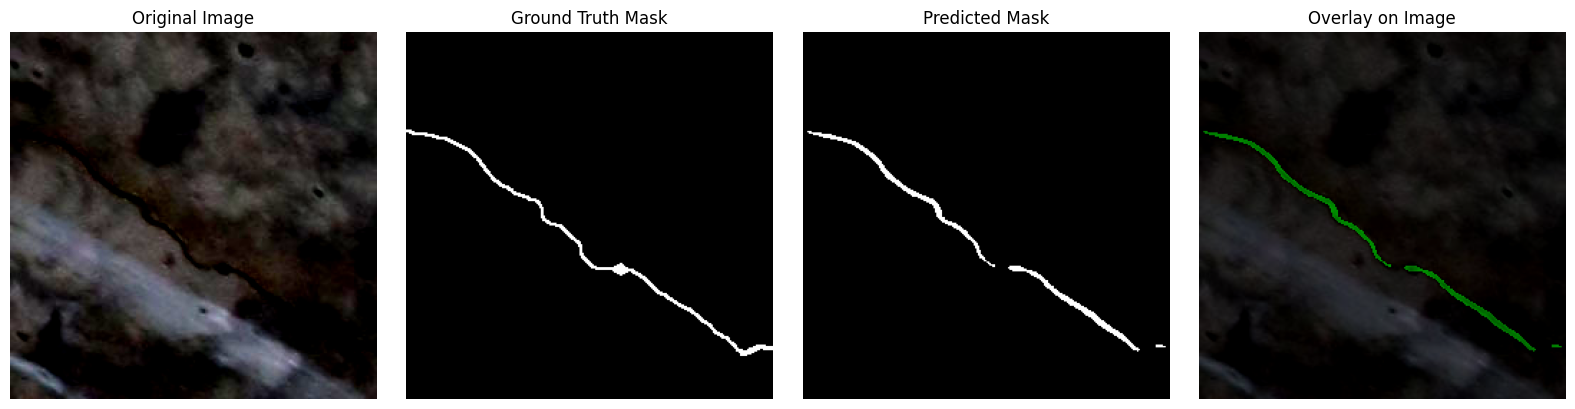

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].


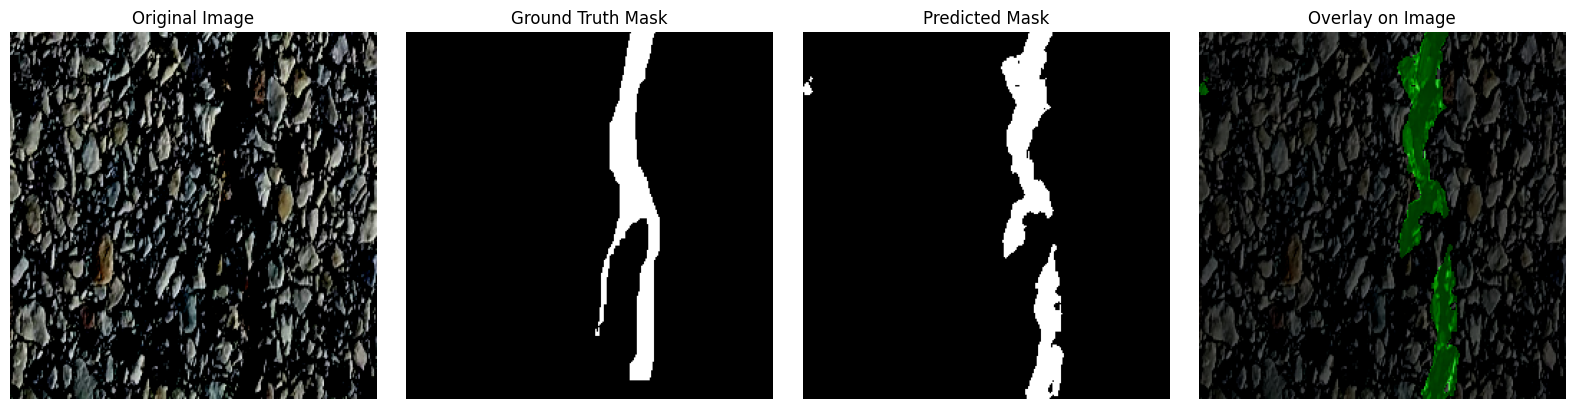

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.827451..0.24705887].


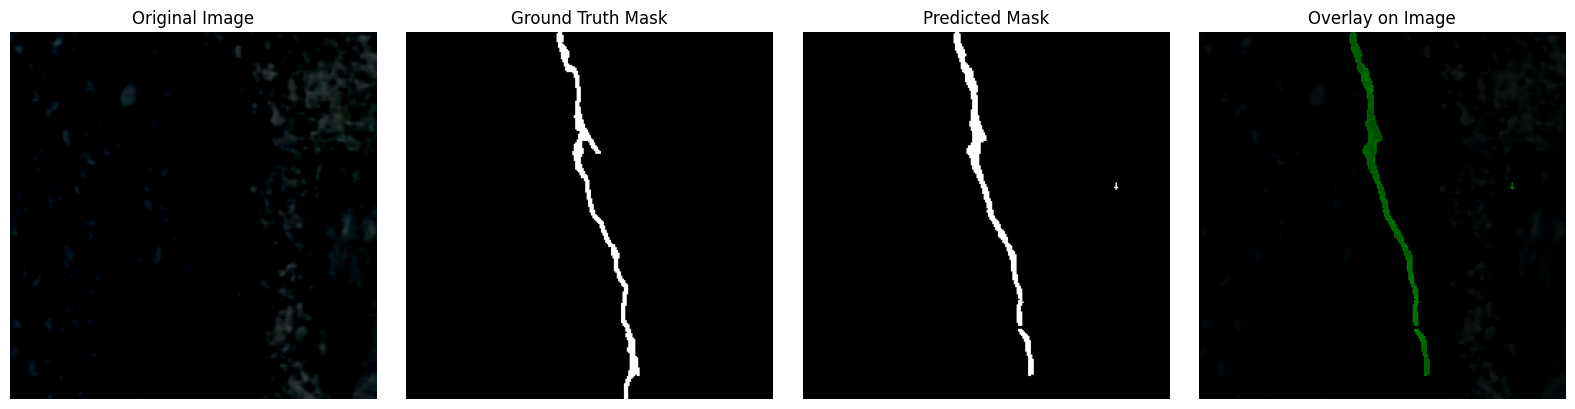

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


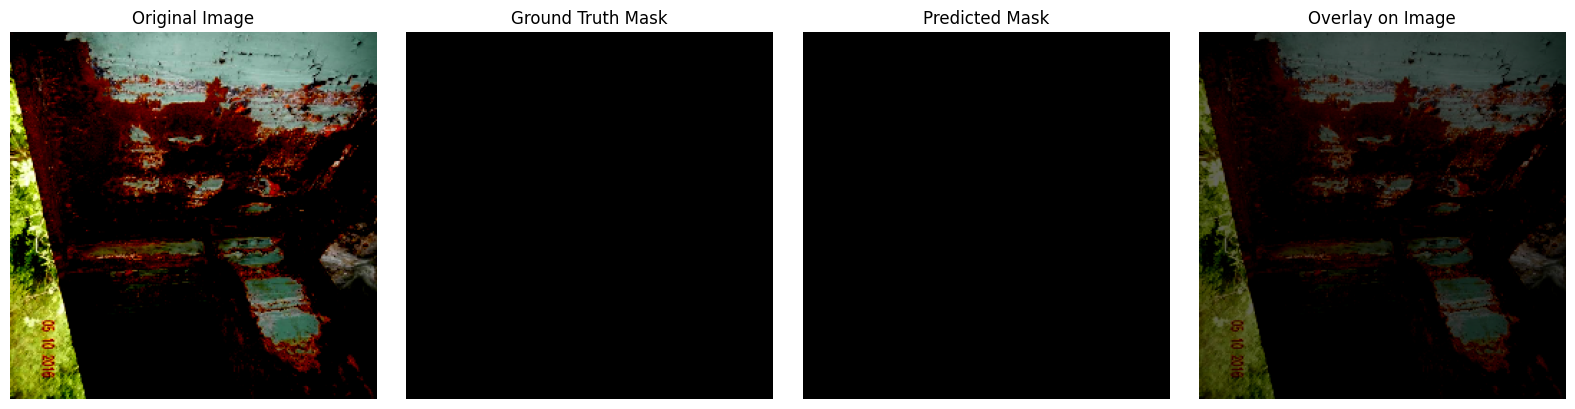

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.62352943].


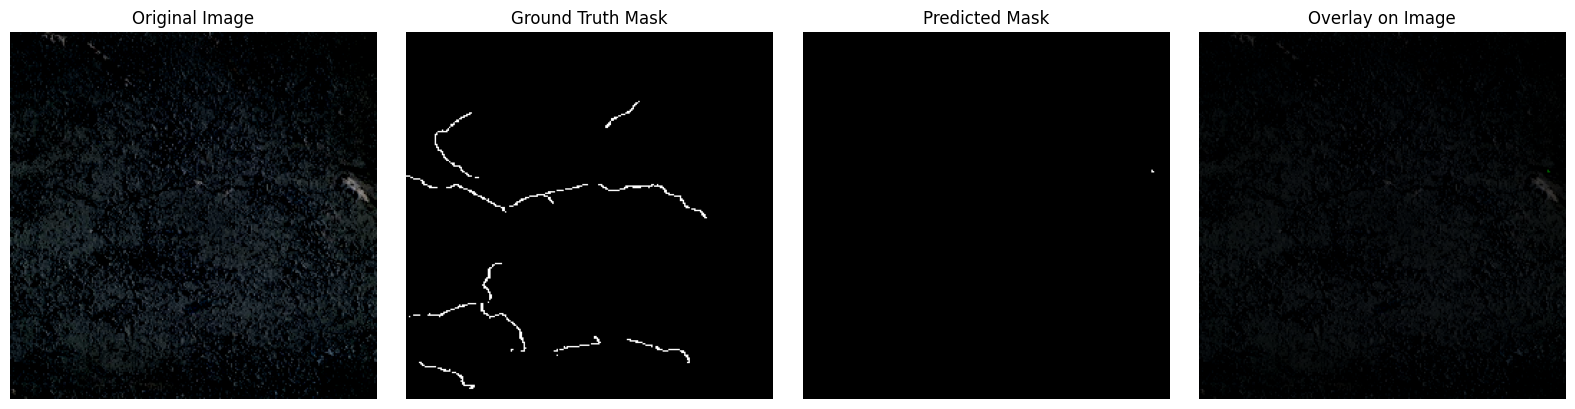


Average Dice Score on Test Set: 0.0494
Average IoU Score on Test Set: 0.0263


In [12]:
model.eval()

# Inference
predict_and_evaluate(model, test_loader, device, save_dir="predicted_masks", threshold=0.5)

#### **Superpixel-Based Refinement via Majority Voting**

In [13]:
from skimage.segmentation import slic
from skimage.color import label2rgb

def generate_superpixels(image, n_segments=300, compactness=10):
    # image must be in HWC format and float
    if image.dtype != np.float32:
        image = image.astype(np.float32) / 255.0

    superpixels = slic(image, n_segments=n_segments, compactness=compactness, start_label=0)
    return superpixels

In [14]:
from scipy import stats

def refine_with_superpixels(pred_mask, superpixels):
    refined_mask = np.zeros_like(pred_mask)

    for label in np.unique(superpixels):
        region_mask = (superpixels == label)
        majority_vote = stats.mode(pred_mask[region_mask].flatten(), keepdims=False).mode
        refined_mask[region_mask] = majority_vote

    return refined_mask

In [16]:
def evaluation_with_superpixels_refinement(model, test_loader, save_dir, threshold=0.5, num_visualize=5):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()

    with torch.no_grad():
        for idx, (images, masks) in enumerate(test_loader):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            preds = torch.sigmoid(outputs)
            preds_bin = (preds > threshold).float()

            for i in range(images.size(0)):
                image = images[i].cpu().permute(1, 2, 0).numpy()
                pred_mask = preds_bin[i].squeeze().cpu().numpy()

                # Now we will Generate Superpixels
                superpixels = generate_superpixels(image, n_segments=300, compactness=10)

                # Then we will apply the refinement
                refined_mask = refine_with_superpixels(pred_mask, superpixels)

                # Save the refined mask
                refined_img = Image.fromarray((refined_mask * 255).astype(np.uint8))
                refined_img.save(os.path.join(save_dir, f"UNet_refined_pred_{idx * test_loader.batch_size + i}.png"))

                if idx * test_loader.batch_size + i < num_visualize:
                    visualize_prediction(torch.tensor(image).permute(2, 0, 1), masks[i], torch.tensor(refined_mask))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7882353..0.7490196].


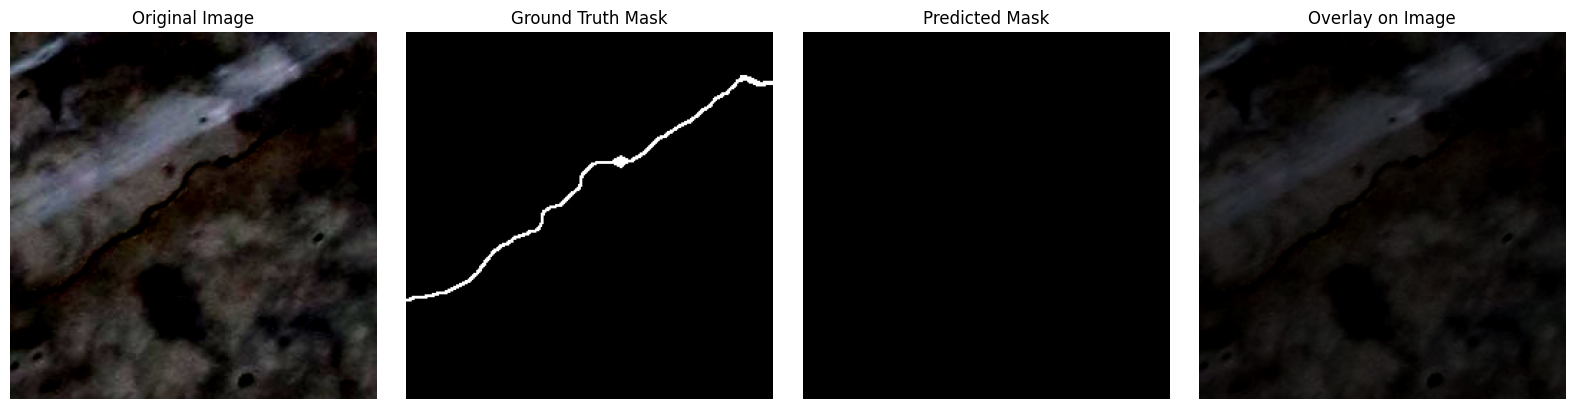

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].


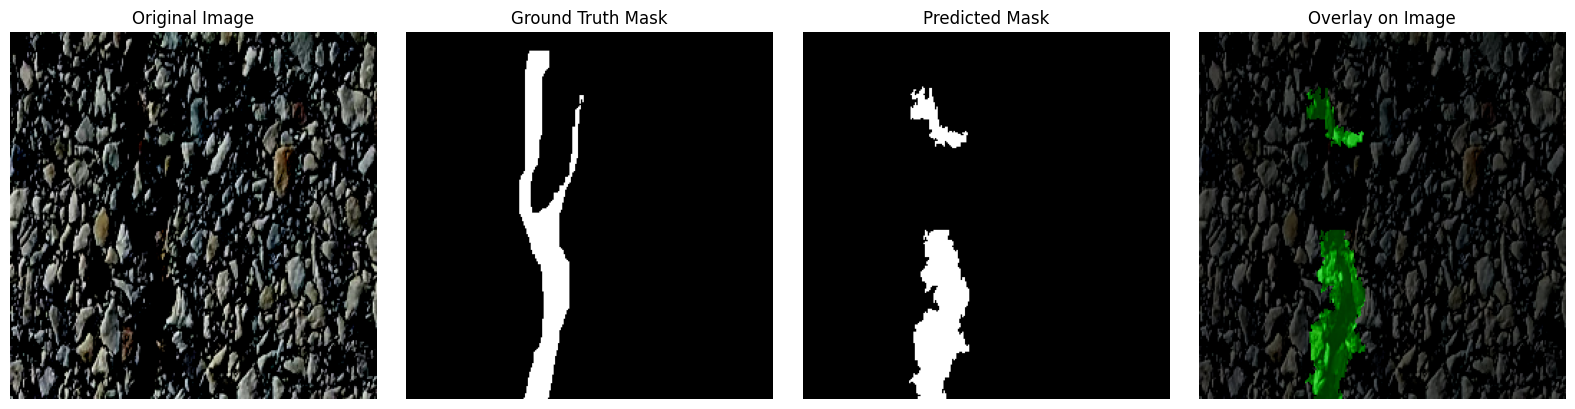

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.827451..0.24705887].


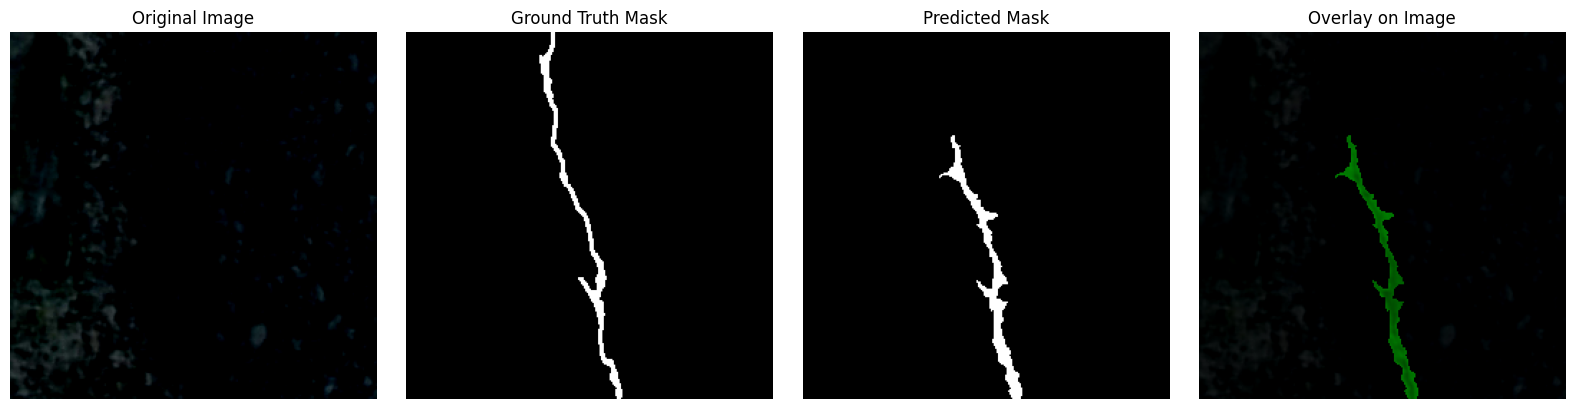

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


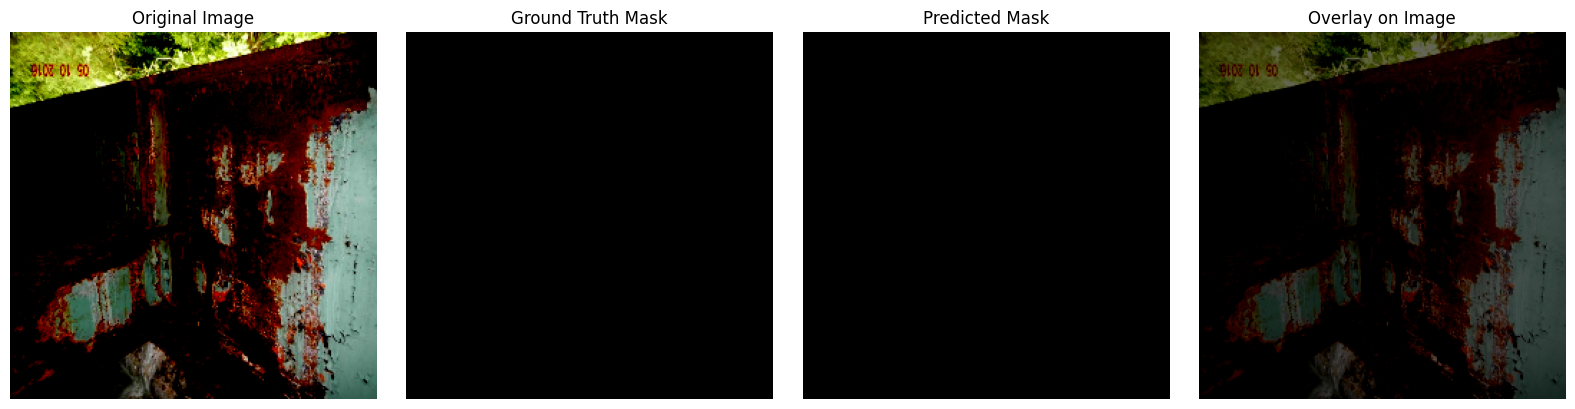

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.62352943].


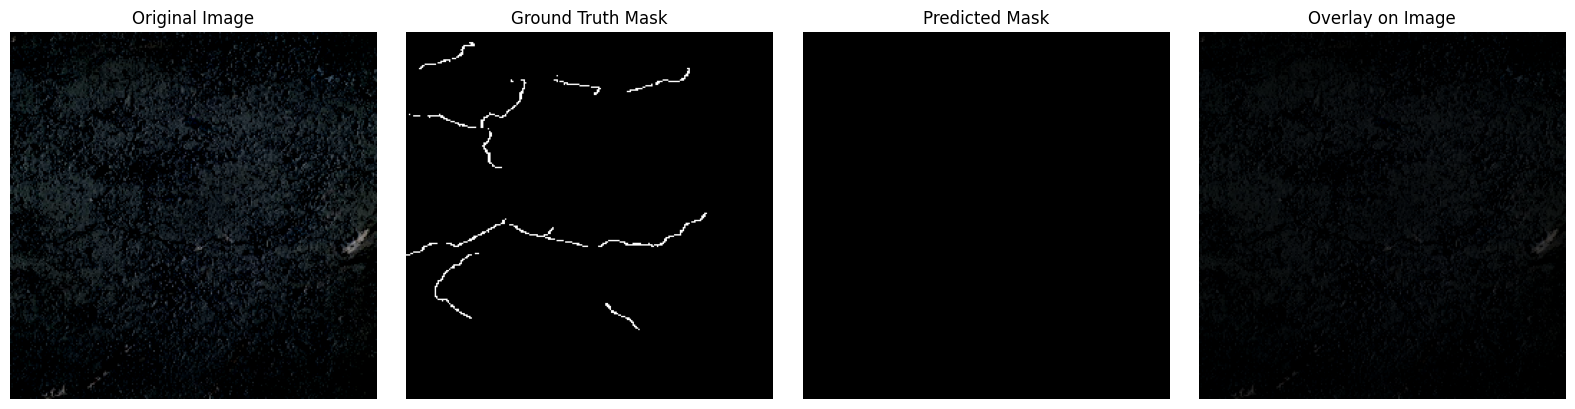

In [17]:
save_dir = "UNet_refined_predicted_masks"
evaluation_with_superpixels_refinement(model, test_loader, save_dir, threshold=0.5)

#### **Region Splitting and Merging-Based Refinement**

In [18]:
import cv2
import numpy as np
from skimage.measure import label, regionprops
from scipy.ndimage import binary_fill_holes
from skimage.morphology import remove_small_objects, remove_small_holes

In [19]:
def region_based_split_and_merge(image, pred_mask, split_variance_thresh=0.01, merge_similarity_thresh=0.1, min_region_size=50):
    
    h, w = pred_mask.shape
    image_gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    labeled_mask = label(pred_mask)

    region_map = np.zeros_like(pred_mask)

    # First is Region Splitting
    label_counter = 1
    for region in regionprops(labeled_mask):
        coords = region.coords
        region_intensity = image_gray[tuple(zip(*coords))]
        region_variance = np.var(region_intensity)

        if region_variance > split_variance_thresh:
            # split into 2 by k-means clustering
            pixels = np.array([image[coord[0], coord[1]] for coord in coords])
            pixels = np.float32(pixels)
            _, labels, _ = cv2.kmeans(pixels, 2, None, 
                                      (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0),
                                      3, cv2.KMEANS_RANDOM_CENTERS)
            labels = labels.flatten()
            for i, coord in enumerate(coords):
                region_map[coord[0], coord[1]] = label_counter + labels[i]
            label_counter += 2
        else:
            for coord in coords:
                region_map[coord[0], coord[1]] = label_counter
            label_counter += 1

    # Step 4.3: Region Merging
    final_map = region_map.copy()
    merged = set()
    for label1 in np.unique(region_map):
        if label1 == 0 or label1 in merged:
            continue

        mask1 = (region_map == label1)
        mean1 = np.mean(image[mask1], axis=0)

        for label2 in np.unique(region_map):
            if label2 == 0 or label2 == label1 or label2 in merged:
                continue

            mask2 = (region_map == label2)
            mean2 = np.mean(image[mask2], axis=0)

            # Merge if similar color mean
            if np.linalg.norm(mean1 - mean2) < merge_similarity_thresh:
                final_map[mask2] = label1
                merged.add(label2)

    # Step 4.4: Optional Morphological Cleaning
    binary_mask = final_map > 0
    binary_mask = binary_fill_holes(binary_mask)
    binary_mask = remove_small_objects(binary_mask, min_size=min_region_size)
    binary_mask = remove_small_holes(binary_mask, area_threshold=min_region_size)

    # Step 4.5: Final Output
    return binary_mask.astype(np.uint8)

In [20]:
def apply_split_merge_refinement(model, test_loader, save_dir, threshold=0.5, num_visualize=5):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()

    with torch.no_grad():
        for idx, (images, masks) in enumerate(test_loader):
            images = images.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs)
            preds_bin = (preds > threshold).float()

            for i in range(images.size(0)):
                image = images[i].cpu().permute(1, 2, 0).numpy()
                pred_mask = preds_bin[i].squeeze().cpu().numpy()

                # Apply Region Splitting and Merging Refinement
                refined_mask = region_based_split_and_merge(image, pred_mask)

                # Save
                refined_img = Image.fromarray((refined_mask * 255).astype(np.uint8))
                refined_img.save(os.path.join(save_dir, f"split_merge_refined_{idx * test_loader.batch_size + i}.png"))

                if idx * test_loader.batch_size + i < num_visualize:
                    visualize_prediction(torch.tensor(image).permute(2, 0, 1), masks[i], torch.tensor(refined_mask))

    print("Region splitting & merging-based refinement complete.")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7882353..0.7490196].


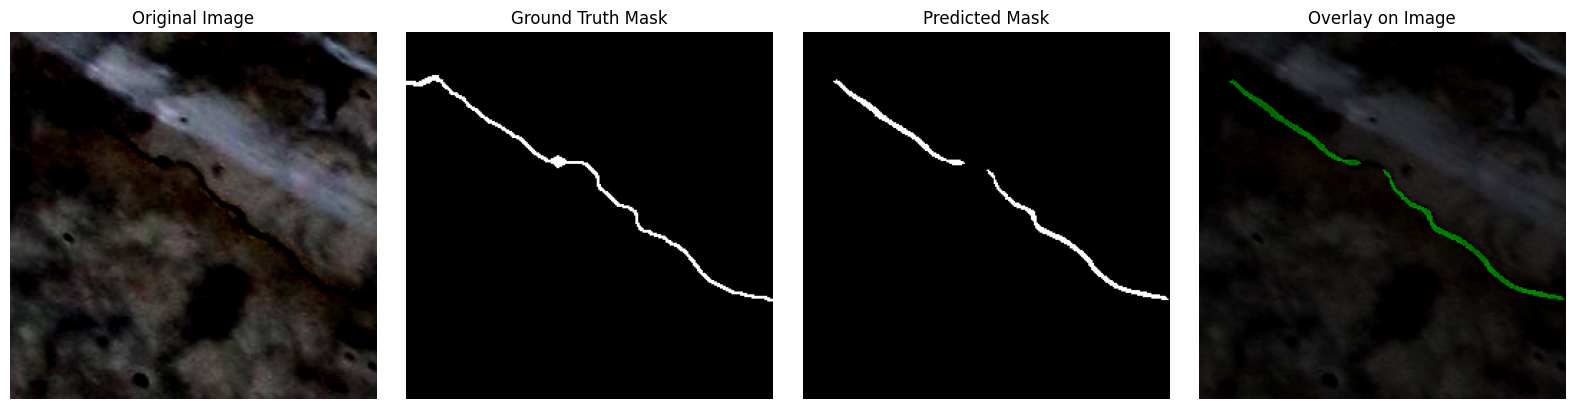

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].


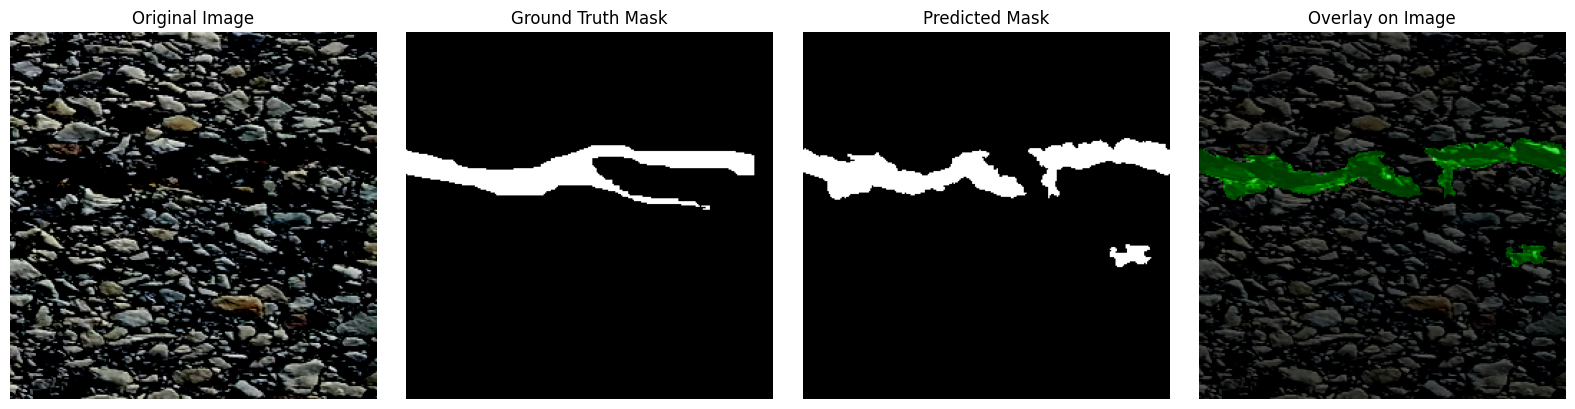

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.827451..0.24705887].


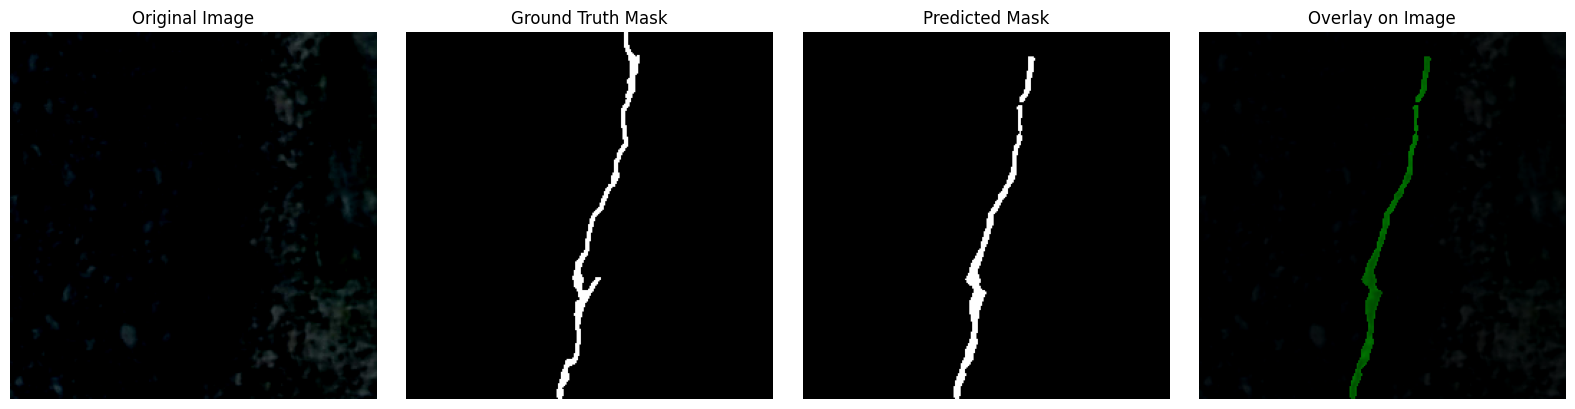

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


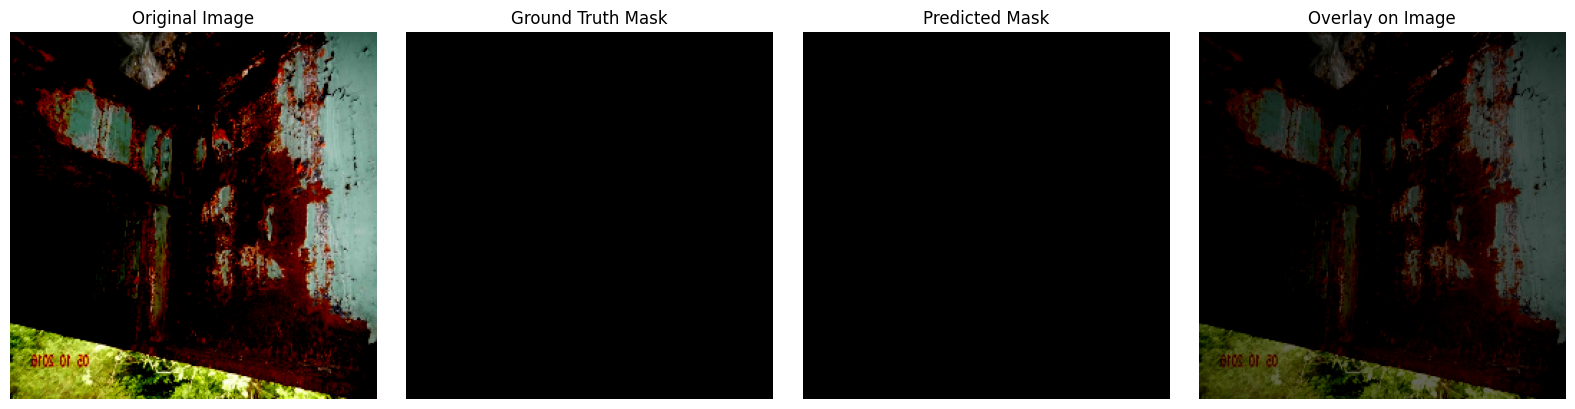

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.62352943].


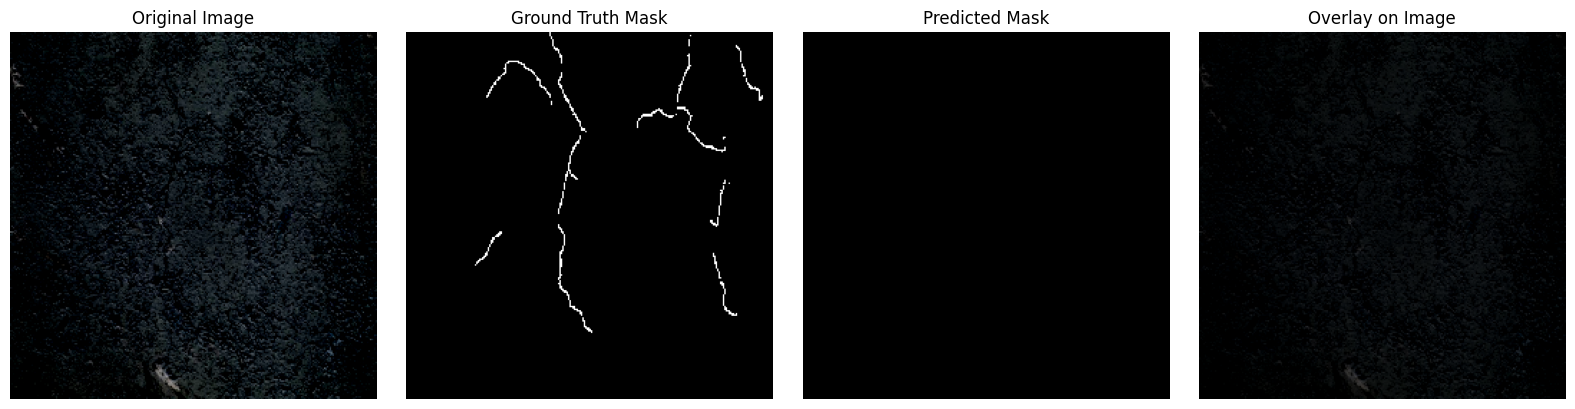

Region splitting & merging-based refinement complete.


In [21]:
save_dir = "UNet_Region_Based"
apply_split_merge_refinement(model, test_loader, save_dir, threshold=0.5)

In [22]:
def visualize_full_pipeline(image, mask, pred_mask, slic_refined, region_refined):
    """
    Display the original image, ground truth, predicted mask, 
    slic-refined mask, and region-based refined mask side by side.
    """
    image = image.cpu().permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
    mask = mask.cpu().squeeze().numpy()
    pred_mask = pred_mask.squeeze()
    slic_refined = slic_refined.squeeze()
    region_refined = region_refined.squeeze()

    fig, axs = plt.subplots(1, 5, figsize=(20, 4))

    axs[0].imshow(image)
    axs[0].set_title("Original Image")

    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title("Ground Truth")

    axs[2].imshow(pred_mask, cmap='gray')
    axs[2].set_title("Predicted Mask")

    axs[3].imshow(slic_refined, cmap='gray')
    axs[3].set_title("SLIC Refined")

    axs[4].imshow(region_refined, cmap='gray')
    axs[4].set_title("Region-Based Refined")

    for ax in axs:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7882353..0.7490196].


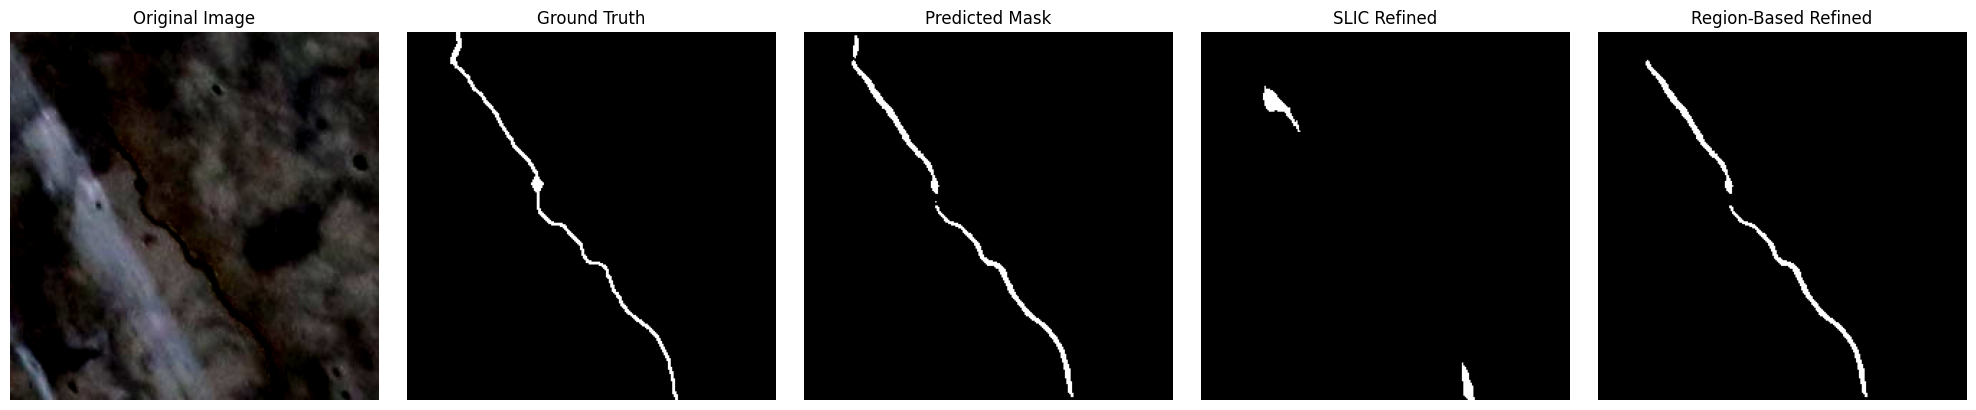

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].


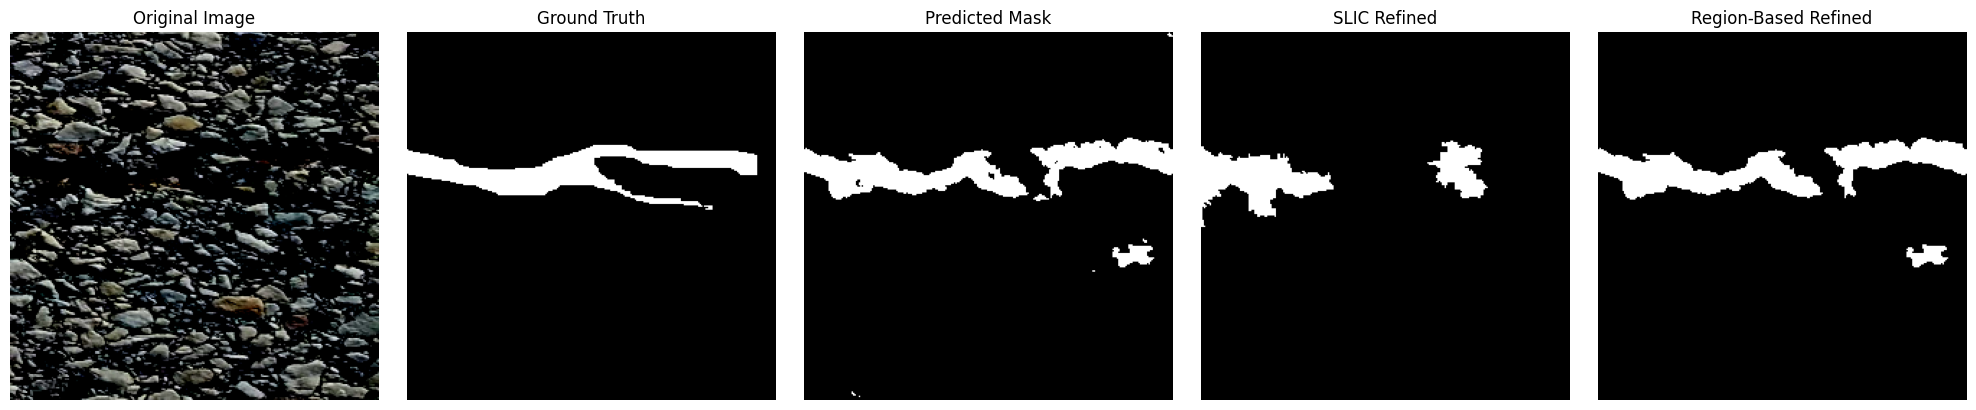

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.827451..0.24705887].


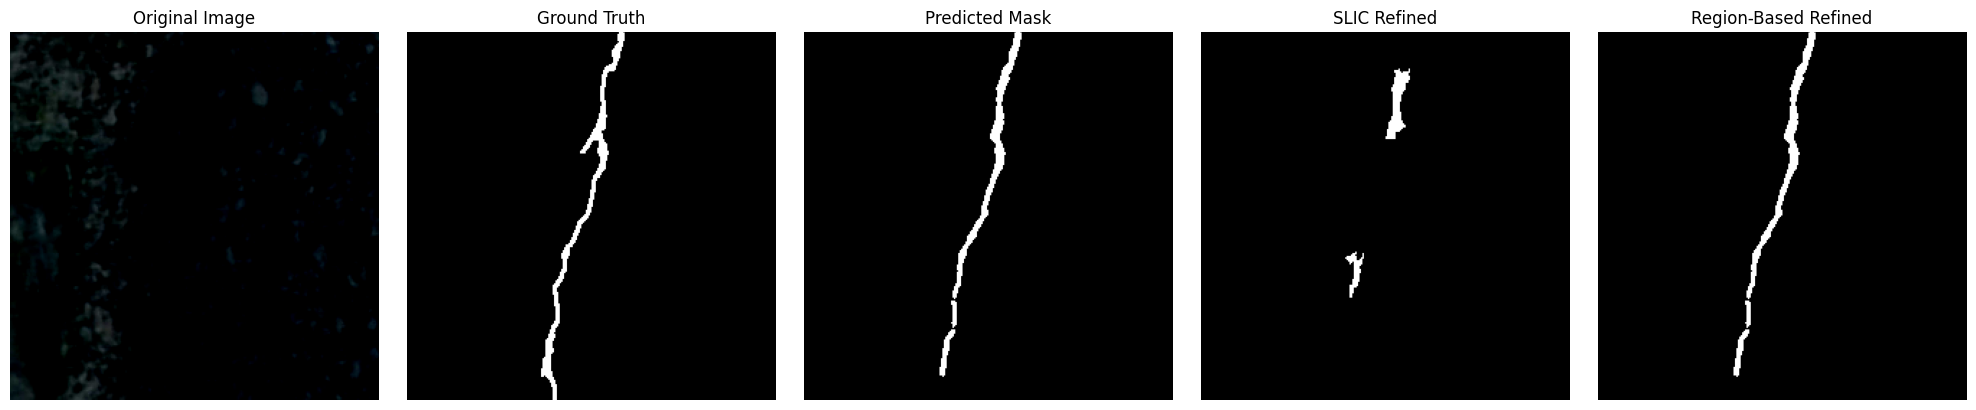

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


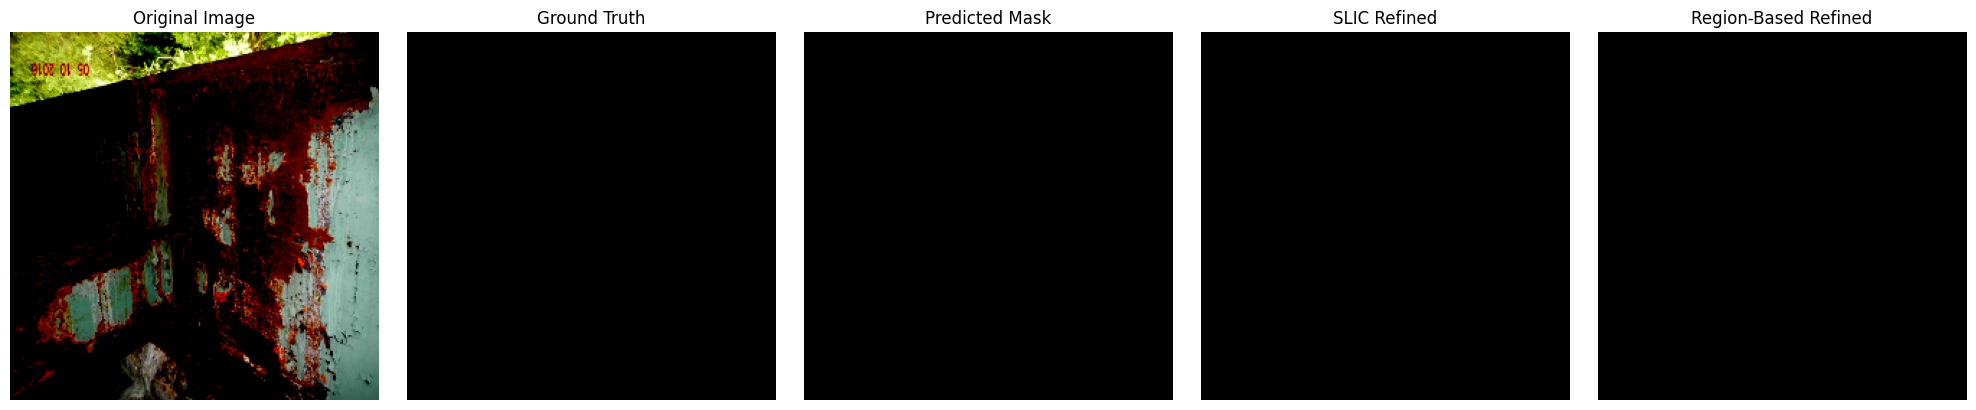

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.62352943].


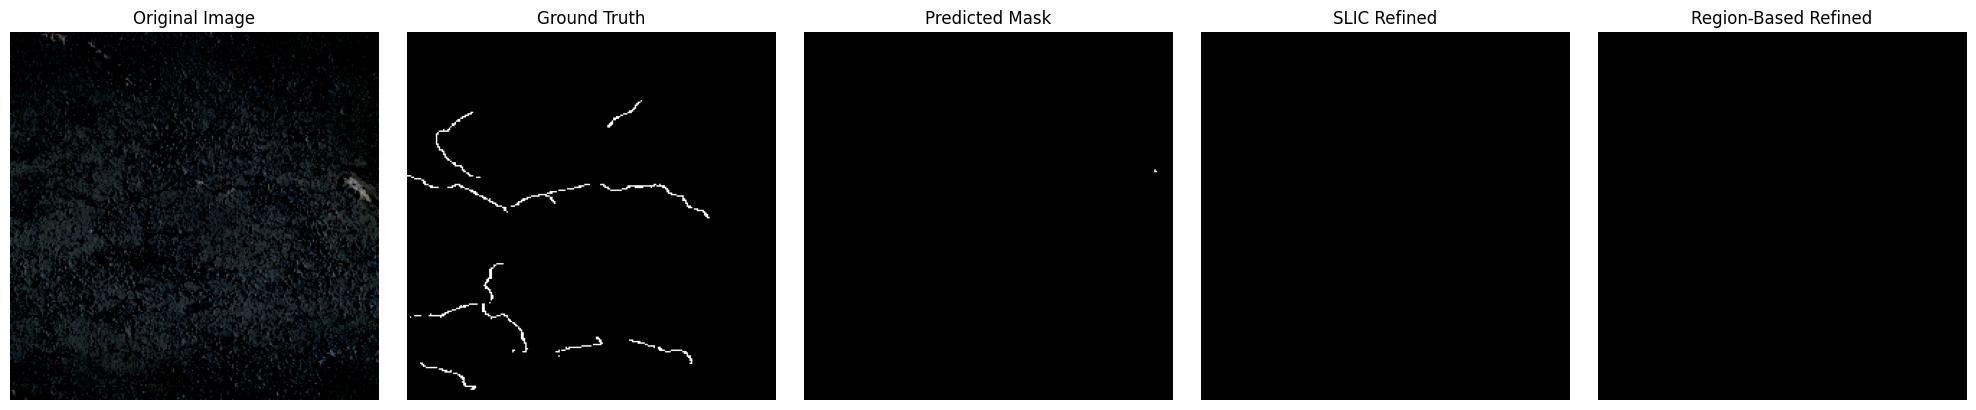

In [23]:
# Visualization for a few test images
num_visualize = 5
model.eval()

with torch.no_grad():
    for idx in range(num_visualize):
        image, mask = test_dataset[idx]
        image_input = image.unsqueeze(0).to(device)

        output = model(image_input)
        pred = torch.sigmoid(output).squeeze().cpu().numpy()
        pred_bin = (pred > 0.5).astype(np.uint8)

        image_np = image.permute(1, 2, 0).numpy()

        # Apply Superpixel refinement
        superpixels = generate_superpixels(image_np)
        slic_refined = refine_with_superpixels(pred_bin, superpixels)

        # Apply Region Splitting & Merging refinement
        region_refined = region_based_split_and_merge(image_np, pred_bin)

        # Show all in one plot
        visualize_full_pipeline(image, mask, pred_bin, slic_refined, region_refined)